# Task 4: Make three non-linear regressions which can predict VF, VU & VD
## VF based on only bitperpixel (e.g. exponential fit)
## VU based on only bitperpixel (e.g. polynomial fit in 3rd order)
## VD based on only framerate (note that it does not give you good result)

In [1]:
# install.packages('dplyr')      # processing 
# install.packages('gdata')      # file reading
# install.packages('tidyverse')  # includes regression algorithms
# install.packages('Hmisc')      # correlation matricies

In [2]:
library(readxl)     # reading in data
library(tidyverse)  # regression algorithms
library(ggplot2)    # residual plot

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


# Global constants for MOS prediction & outlier removal (optional)

In [3]:
# VU, VF, VD, VQ values are each MOS of these attributes
predict_MOS <- TRUE

# optional univariate outlier removal
remove_univariate_outliers <- TRUE

# Getter for input data set based on global constants (features from Task 1, Task 2 included)

In [4]:
get_gaming_data <- function() {
    # read in data set
    gaming_data <- read_excel("datasets/DB01_gaming_video_quality_dataset.xlsx")
    
    # Compute MOS per Game, Condition [Task 1] 
    mos_per_condition_and_game <- gaming_data %>%
                              dplyr::group_by(Game, Condition) %>%
                              dplyr::summarise(meanVQ = mean(VQ), meanVF = mean(VF), meanVU = mean(VU), meanVD = mean(VD)) %>%
                              dplyr::select(Game, Condition, meanVQ, meanVF, meanVU, meanVD)
    
    # Feature Transformation [Task 2]
    gaming_data_feature_transformation <- gaming_data %>% 
                                        dplyr::mutate(Number_Of_Pixels = ifelse(Resolution == 480, 480*720, 
                                                                    ifelse(Resolution == 720, 720*1280, 
                                                                          ifelse(Resolution == 1080, 1080*1920, -1)
                                                                          )
                                                                  )
                                              ) %>%
                                        dplyr::mutate(Bits_Per_Pixel = Bitrate / Number_Of_Pixels) %>%
                                        dplyr::select(Game, Condition, VF, VU, VD, VQ, Framerate, Number_Of_Pixels, Bits_Per_Pixel)
    
    # Merge data for single data source
    gaming_data <- merge(mos_per_condition_and_game, gaming_data_feature_transformation)
    
    # either predict MOS values OR single ratings
    if(predict_MOS) {
        gaming_data <- unique(gaming_data %>% dplyr::select(Game, Condition, meanVQ, meanVF, meanVU, meanVD, Framerate, Number_Of_Pixels, Bits_Per_Pixel)) %>% 
                       rename(VF = meanVF, VU = meanVU, VD = meanVD, VQ = meanVQ) %>% 
                       arrange(Game, Condition)
    } else {
        gaming_data <- gaming_data %>% 
                       arrange(Game, Condition)
    }
    
    # formatting
    rownames(gaming_data) <- NULL
    
    # optional outlier removal (only univariate outliers in VD)
    if(remove_univariate_outliers) {
        bounds <- gaming_data %>% summarise(lower = quantile(VD, c(0.25)), upper = quantile(VD, c(0.75))) %>% 
                        mutate(IQR = upper - lower) %>% 
                        mutate(lower_bound_VD = lower - 1.5*IQR, upper_bound_VD = upper + 1.5*IQR) %>% 
                        dplyr::select(lower_bound_VD, upper_bound_VD)

        gaming_data <- gaming_data %>% 
                            dplyr::filter(VD >= as.double(bounds$lower_bound_VD)) %>% 
                            dplyr::filter(VD <= as.double(bounds$upper_bound_VD))
    }
    
    gaming_data
}

get_gaming_data()

Game,Condition,VQ,VF,VU,VD,Framerate,Number_Of_Pixels,Bits_Per_Pixel
Game1,4,2.948,2.796,3.204,4.840,30,921600,0.0010850694
Game1,5,4.112,3.760,4.392,4.924,30,2073600,0.0019290123
Game1,15,1.988,2.232,2.260,5.092,30,345600,0.0008680556
Game1,19,3.068,3.724,2.876,5.092,60,345600,0.0057870370
Game1,25,5.080,5.340,4.544,5.536,60,921600,0.0542534722
Game1,33,2.568,2.344,3.208,4.744,60,921600,0.0010850694
Game1,34,2.740,3.400,2.440,4.956,60,345600,0.0028935185
Game1,35,3.876,4.936,3.368,5.316,60,345600,0.0173611111
Game1,36,2.964,2.492,4.216,4.916,60,2073600,0.0009645062
Game1,39,4.424,4.584,4.252,4.972,30,921600,0.0043402778


# Set input data set globally for reusability

In [5]:
# make data set globally accessible for reusability
gaming_data <- get_gaming_data()

# Define reusable function for drawing scatter plots

In [6]:
# draws simple scatter plot for two requested features 
# includes fitted model if model passed
draw_scatter_for <- function(target, model=NULL) {
    if(target == 'VF' || target == 'VU') {
        predictor <- 'Bits_Per_Pixel'
    } else {
        target <- 'VD'
        predictor <- 'Framerate'
    }
    
    data <- get_gaming_data()
    
    if(missing(model) || is.null(model)) {
        data <- as.data.frame(cbind(data %>% dplyr::select(predictor), data %>% dplyr::select(target)))
    
        return(ggplot(data, aes_string(x = predictor, y = target)) + 
                geom_point(color="darkred") + 
                scale_y_continuous(breaks=seq(0,7,1)) + 
                coord_cartesian(ylim=c(1,7)) + 
                labs(x = predictor, y = target) + 
                theme( panel.background = element_rect(fill = '#d7f5f2', colour = 'darkred'), strip.background = element_rect(fill='#d7f5f2', colour = 'darkred'),
                                      strip.text = element_text(size=15, colour='darkred')) + 
                labs(x = predictor, y = target) + 
                ggtitle(paste0('Scatter Plot for Non-Linear Regression Model: ', predictor, ' -> ', target)) + 
                geom_smooth(method="loess"))
    } else {
        data <- data %>% select_(predictor, target) %>% arrange_(predictor)
        plot(data, xlab = predictor, ylab = target, ylim = c(1,7), col = 34, main=paste0('Predicted Model for Non-Linear Regression Model: \n', predictor, ' -> ', target), bg = 44, pch=20)
        lines(as.vector(data[[predictor]]), predict(model))
    }
}

# Get visual intuition for data before selecting model

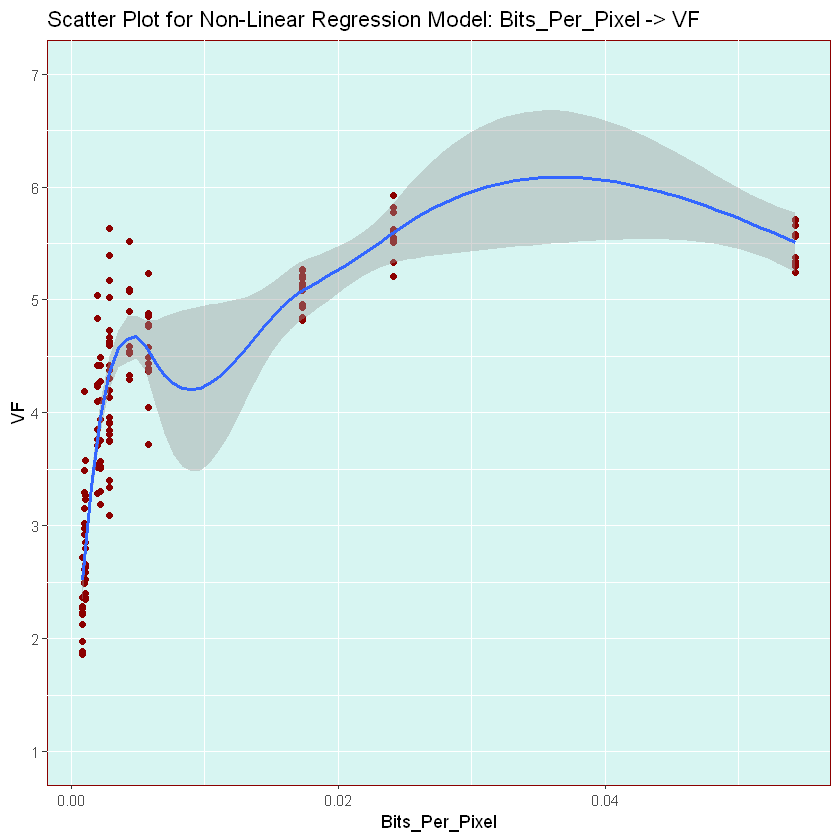

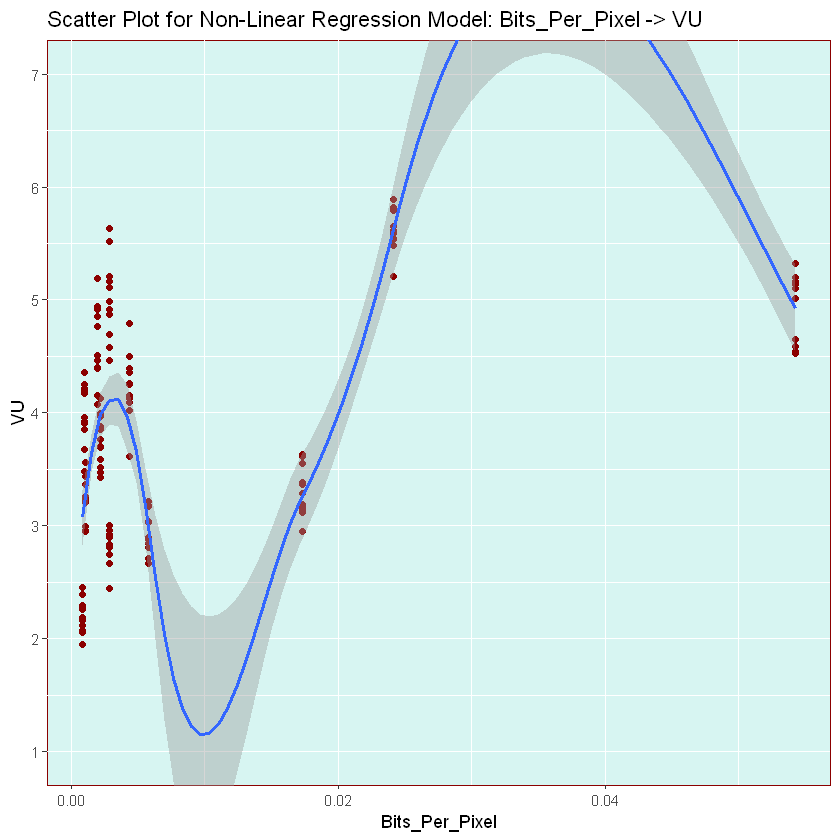

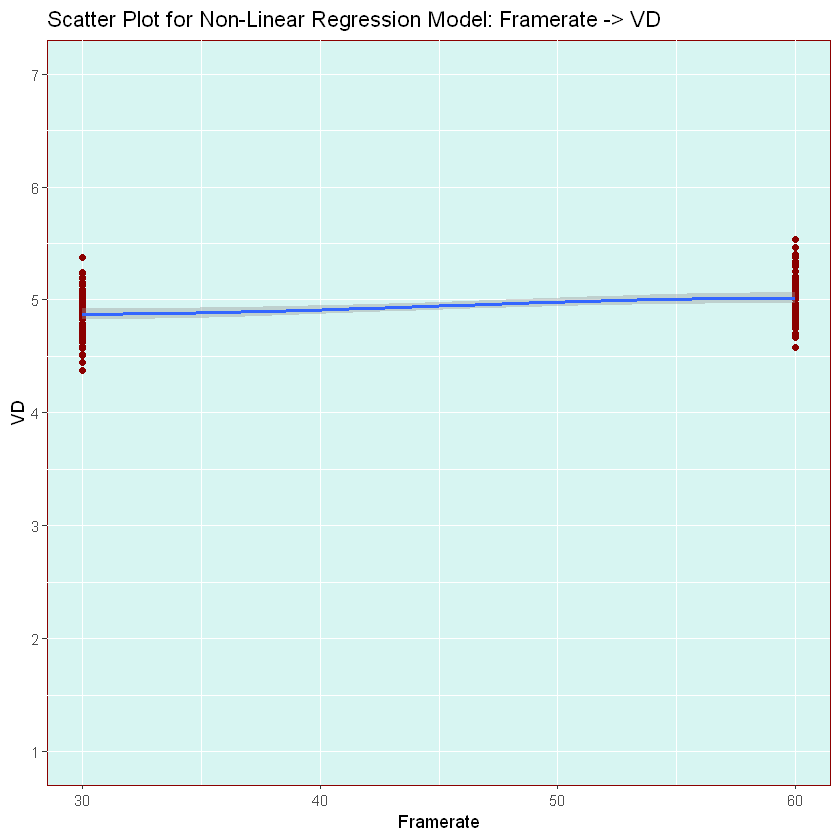

In [7]:
draw_scatter_for('VF')
draw_scatter_for('VU')
draw_scatter_for('VD')

# Trial & Error: Find good enough function that fits data points


Formula: VF ~ a * log(Bits_Per_Pixel) - exp(b * Bits_Per_Pixel) - c

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a   1.02640    0.05541  18.524   <2e-16 ***
b  17.84881    1.81889   9.813   <2e-16 ***
c -11.04943    0.33645 -32.841   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5251 on 140 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.566e-06


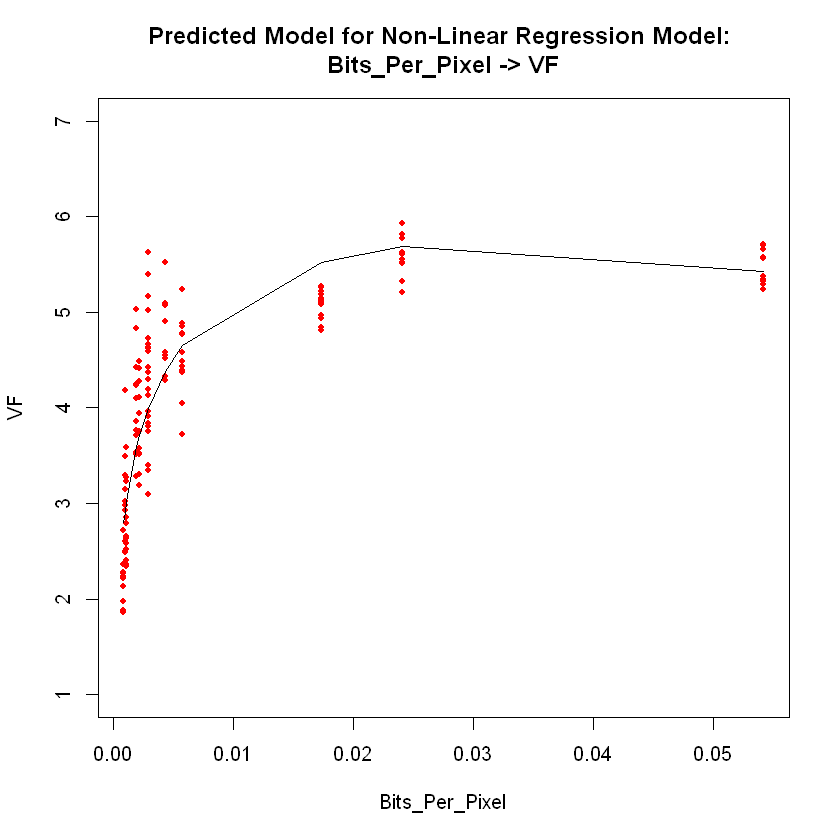


Formula: VU ~ a * Bits_Per_Pixel^5 + b * Bits_Per_Pixel^4 + c * Bits_Per_Pixel^3 + 
    d * Bits_Per_Pixel^2 + e * Bits_Per_Pixel + f

Parameters:
    Estimate Std. Error t value Pr(>|t|)    
a  1.160e+10  1.928e+09   6.017 1.53e-08 ***
b -1.211e+09  1.949e+08  -6.216 5.76e-09 ***
c  4.023e+07  6.163e+06   6.529 1.19e-09 ***
d -5.069e+05  7.370e+04  -6.877 1.98e-10 ***
e  2.055e+03  2.874e+02   7.151 4.71e-11 ***
f  1.596e+00  2.972e-01   5.369 3.29e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6781 on 137 degrees of freedom

Number of iterations to convergence: 3 
Achieved convergence tolerance: 2.826e-08


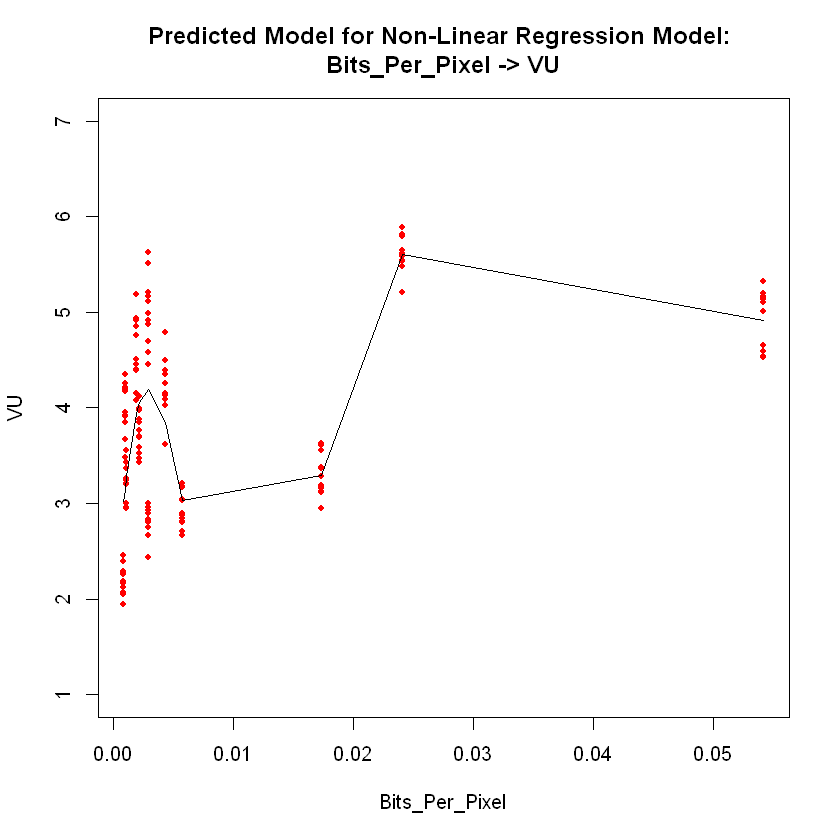


Formula: VD ~ a * Framerate + c

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a 0.004748   0.001142   4.157 5.56e-05 ***
c 4.731929   0.054282  87.174  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2048 on 141 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 2.129e-10


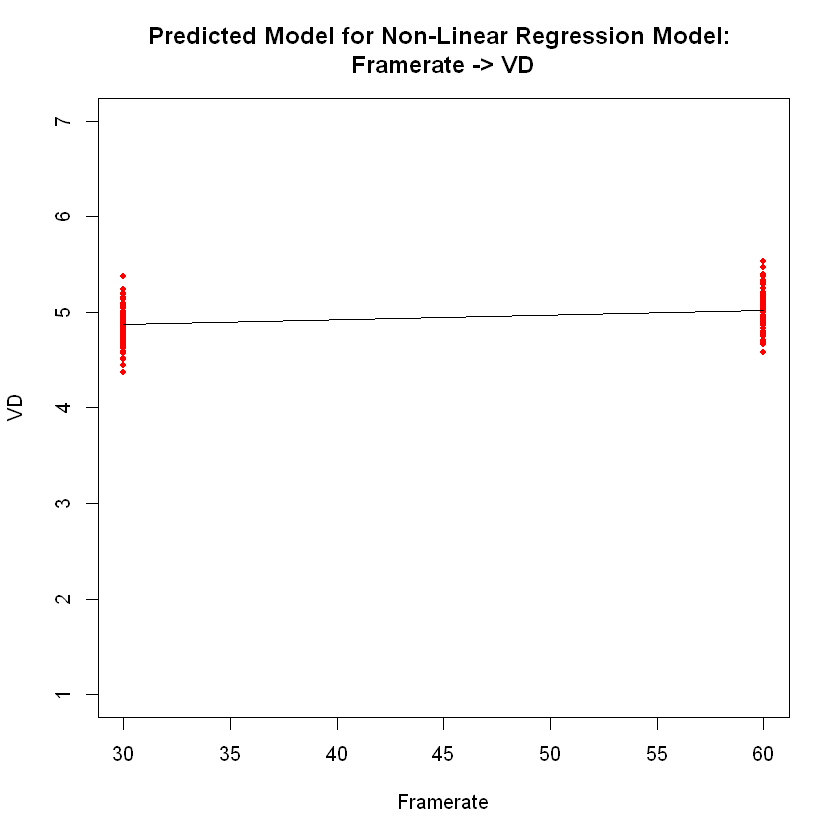

In [8]:
# note: higher degrees of freedom leads to overfitting
data <- gaming_data %>% dplyr::select(Bits_Per_Pixel, VF, VU) %>% arrange(Bits_Per_Pixel)
VF_model <- nls(VF ~ a * log ( Bits_Per_Pixel ) - exp( b * Bits_Per_Pixel) - c, 
                data = data, start = c(a = -10000, b = -10, c = -10001))
draw_scatter_for('VF', VF_model)
summary(VF_model)

VU_model <- nls(VU ~ a*Bits_Per_Pixel^5 + b*Bits_Per_Pixel^4 + c*Bits_Per_Pixel^3 + 
                d*Bits_Per_Pixel^2 + e*Bits_Per_Pixel + f, 
                data = data, start = c(a = -10000, b = -10000, c = -10000, d = -10000, e = -10000, f = -10000))
draw_scatter_for('VU', VU_model)
summary(VU_model)

data <- gaming_data %>% dplyr::select(Framerate, VD) %>% arrange(Framerate)
VD_model <- nls(VD ~ a*Framerate + c, data = data, start = c(a = -10000, c = -10000))
draw_scatter_for('VD', VD_model)
summary(VD_model)

#### Note: Every single p value of coeffients smaller than 0.05!

# Display predicted values for VU, VD & VF

In [9]:
# get predicted values
VF_predicted <- predict(nls(VF ~ a * log ( Bits_Per_Pixel ) - exp( b * Bits_Per_Pixel) - c, data = gaming_data, start = c(a = -10000, b = -10, c = -10001)))
VU_predicted <- predict(nls(VU ~ a*Bits_Per_Pixel^5 + b*Bits_Per_Pixel^4 + c*Bits_Per_Pixel^3 + d*Bits_Per_Pixel^2 + e*Bits_Per_Pixel + f, data = gaming_data, start = c(a = -10000, b = -10000, c = -10000, d = -10000, e = -10000, f = -10000)))

VD_predicted <- predict(nls(VD ~ a*Framerate + c, data = gaming_data, start = c(a = -10000, c = -10000)))

# merge predicted and true values
VF_data <- cbind(gaming_data %>% dplyr::select(Game, Condition, VF), VF_predicted)
VU_data <- cbind(gaming_data %>% dplyr::select(VU), VU_predicted)
VD_data <- cbind(gaming_data %>% dplyr::select(VD), VD_predicted)

# display results
model_results <- cbind(VF_data, VU_data, VD_data)
model_results

Game,Condition,VF,VF_predicted,VU,VU_predicted,VD,VD_predicted
Game1,4,2.796,3.023578,3.204,3.278306,4.840,4.874356
Game1,5,3.760,3.598656,4.392,3.945806,4.924,4.874356
Game1,15,2.232,2.798486,2.260,3.023101,5.092,4.874356
Game1,19,3.724,4.652483,2.876,3.027299,5.092,5.016783
Game1,25,5.340,5.424799,4.544,4.916152,5.536,5.016783
Game1,33,2.344,3.023578,3.208,3.278306,4.744,5.016783
Game1,34,3.400,3.996851,2.440,4.189996,4.956,5.016783
Game1,35,4.936,5.525654,3.368,3.293702,5.316,5.016783
Game1,36,2.492,2.904878,4.216,3.141133,4.916,5.016783
Game1,39,4.584,4.385473,4.252,3.843911,4.972,4.874356
